<a href="https://colab.research.google.com/github/chavezoscar/CIT99F19_Dev_0/blob/master/snn_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

Importing data from computer. Then, using Padnas to import into dataframe and read from csv file

In [2]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/data/IMDB Dataset.csv'
movie_reviews = pd.read_csv(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Check for NULL value and shape data into tuple (shape of 5000, 2)

In [3]:

movie_reviews.isnull().values.any()
movie_reviews.shape

(50000, 2)

Testing to see if data is loaded
Data loads, but bad format

In [4]:
movie_reviews.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Check distribution of positive / negative revies in data set using seaborn (like mathplot lib)

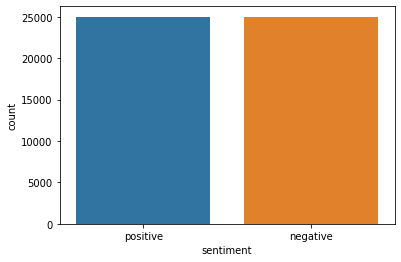

In [5]:
import seaborn as sns
sns.countplot(x="sentiment", data=movie_reviews)

Clean up and process data using funciton that removes special characters such as html tags. 

In [0]:
def preprocess_text(sen):
  # strip html
  sentence = remove_tags(sen)
  # remove punctuation
  sentence = re.sub('[^a-zA-z]', ' ', sentence)
  # remove single chars
  sentence = re.sub(r"\s+[a-zA-z]\s+", ' ', sentence)
  # remove multiple spaces 
  sentence = re.sub(r'\s+', ' ', sentence)

  return sentence

TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
  return TAG_RE.sub('', text)


Preprocess reviws and store in array

In [0]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
  X.append(preprocess_text(sen))

check new formatted text

In [8]:
X[3]

'Basically there a family where little boy Jake thinks there a zombie in his closet his parents are fighting all the time This movie is slower than soap opera and suddenly Jake decides to become Rambo and kill the zombie OK first of all when you re going to make film you must Decide if its thriller or drama As drama the movie is watchable Parents are divorcing arguing like in real life And then we have Jake with his closet which totally ruins all the film expected to see BOOGEYMAN similar movie and instead watched drama with some meaningless thriller spots out of just for the well playing parents descent dialogs As for the shots with Jake just ignore them '

Convert sentiments (positive / negative labels) into 1 and 0

In [0]:
y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x =="positive" else 0, y)))


Split data sets into training and testing using method from sklearn, 80% training and 20% for testing, we can adjust these numbers by changing test_size to reflecting testing percentage

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

**Embedding Layer**
Keras Tokenizer lets us create an word-to-index dictionary. What this does is converts words to values. 

In [0]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)



Data Padding, filling in bits  and finding vocabulary size. 

We have to set the maximum size of lists of data  to pad data. Helps processing. 

In [0]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)


We create matrices here of features and then embedd and create dictionary of keys(words) to values

In [0]:
from numpy import array
from numpy import asarray
from numpy import zeros

# creating a new empty dictionary
embeddings_dictionary = dict()

glove_file = open('/content/drive/My Drive/data/glove.6B.100d.txt', encoding='utf8')

for line in glove_file:
  records = line.split()
  word = records[0]
  vector_dimensions = asarray(records[1:], dtype='float32')
  embeddings_dictionary [word] = vector_dimensions

glove_file.close()

Create matrix where each row corresponds to indext of the word in dictionary

In [0]:
# creates array with shape and filled with 0s
embedding_matrix = zeros((vocab_size, 100))

for word, index in tokenizer.word_index.items():
  embedding_vector = embeddings_dictionary.get(word)
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector


Create model with simple neural network 
1. Create a sequntial model
2. create embedding layer
3. We are not training our own embedding layer so set to False
4. Weights (our own values for what word are positive or negative get passed in from our own data)
5. add layers to model

In [0]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)

model.add(embedding_layer)
#Simple Neural Network
# model.add(Flatten())
# trying different models Long Short Term Memory Newtork with 128 neurons
from keras.layers.recurrent import LSTM
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

Compile model and show summary

In [51]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 9,372,077
Trainable params: 117,377
Non-trainable params: 9,254,700
_________________________________________________________________
None


Training model
fit method to train neural nework, we are only using 20% of our data to train (validation_split)

In [52]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Train on 32000 samples, validate on 8000 samples
Epoch 1/6
32000/32000 [==============================] - 77s 2ms/step - loss: 0.6020 - acc: 0.6626 - val_loss: 0.4724 - val_acc: 0.7920
Epoch 2/6
32000/32000 [==============================] - 76s 2ms/step - loss: 0.4393 - acc: 0.7984 - val_loss: 0.4073 - val_acc: 0.8134
Epoch 3/6
32000/32000 [==============================] - 77s 2ms/step - loss: 0.3877 - acc: 0.8239 - val_loss: 0.3700 - val_acc: 0.8334
Epoch 4/6
32000/32000 [==============================] - 77s 2ms/step - loss: 0.3628 - acc: 0.8396 - val_loss: 0.3587 - val_acc: 0.8390
Epoch 5/6
32000/32000 [==============================] - 76s 2ms/step - loss: 0.3401 - acc: 0.8505 - val_loss: 0.3527 - val_acc: 0.8485
Epoch 6/6
32000/32000 [==============================] - 77s 2ms/step - loss: 0.3184 - acc: 0.8618 - val_loss: 0.3667 - val_acc: 0.8430


Evaluate perfomance

In [53]:
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score: ", score[0])
print("Test Accuracy: ", score[1])

10000/10000 [==============================] - 9s 946us/step
Test Score:  0.36450932698249816
Test Accuracy:  0.8457


Plotting accuracy and loss

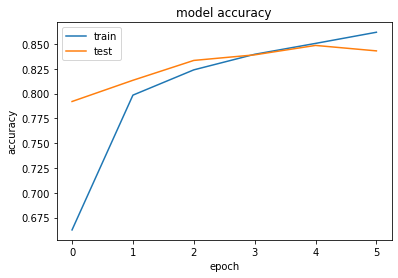

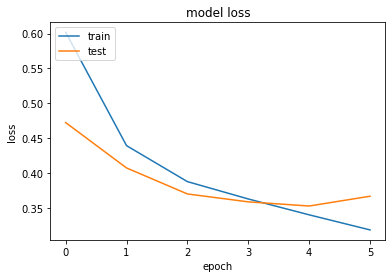

In [54]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')

RNN is giving us best results since data overfitting is not happening 

Making a prediction on a few instances

In [56]:
mediocreReview = 'I appreciate the clear success criteria and learning objective still being present so that S can refer to it with a sub especially in the case if Lopez had to step out'
badReview = 'Students finish the warm up then listen to Chavez explain the lesson Directs listen to the introduction and copy annotations modeled by the teacher Lopez redirects distracted students Consider how we might assess students prior knowledge to know the appropriate starting place and help them build schema. Some guiding questions prior to annotating the notes might be a quick opportunity. Thanks for building in the formative assessment opportunity. Consider what additional opportunity might exist in some structured conversation'
kindaPositive = 'While some students finish testing others read and annotate an article in news Students are to identify the topic and central idea of every paragraph Thanks for providing not testing students with a meaningful activity that aligns with your unit objectives while being flexible to allow others to finish testing Inconvenient but you are making it work'
genericReview = 'Thanks for facilitating class norms by hearing from your students We have learned that students having a voice leads to ownership and higher engagementso Im sure you all have a great year'

# change text to sequence of nums
instance = tokenizer.texts_to_sequences(mediocreReview)

#array-ify
flat_list = []
for sublist in instance:
  for item in sublist:
    flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model.predict(instance)

array([[0.56903857]], dtype=float32)

Mediocre = should be in the middle and prediction comes out about 56% percent :)


In [59]:
# change text to sequence of nums
instance2 = tokenizer.texts_to_sequences(badReview)

#array-ify
flat_list = []
for sublist in instance2:
  for item in sublist:
    flat_list.append(item)

flat_list = [flat_list]

instance2 = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model.predict(instance2)

array([[0.64932656]], dtype=float32)

bad = expeced to be negative, but ends up at 64% so more on positive :/

In [61]:
# change text to sequence of nums
instance3 = tokenizer.texts_to_sequences(kindaPositive)

#array-ify
flat_list = []
for sublist in instance3:
  for item in sublist:
    flat_list.append(item)

flat_list = [flat_list]

instance3 = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model.predict(instance3)

array([[0.94197834]], dtype=float32)

kinda positive = came out to positive at 94% :)

In [62]:
# change text to sequence of nums
instance4 = tokenizer.texts_to_sequences(genericReview)

#array-ify
flat_list = []
for sublist in instance4:
  for item in sublist:
    flat_list.append(item)

flat_list = [flat_list]

instance4 = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model.predict(instance4)

array([[0.7545239]], dtype=float32)

Generic review came out to 75 which is more on the positive side, but if we skew our data and we can all this a C which is most common grade :)